In [20]:
from dataclasses import dataclass
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from src.hrv_epatch.io.data_loader import Load_full_ecg_data
from typing import List, Optional, Tuple


@dataclass
class SeizureEvent:
    seizure_id: int
    t0: float   # sekunder fra recording start
    t1: float   # sekunder fra recording start


def build_seizure_events_from_df(
    seizure_df: pd.DataFrame,
    recording_start: pd.Timestamp,
) -> List[SeizureEvent]:
    """Lav en liste af SeizureEvent (t0/t1 i sek fra recording start).

    Bruger kun EEG/kliniske tider hvis BÅDE start og stop kan parses til gyldige datotider.
    """
    events: List[SeizureEvent] = []

    for _, row in seizure_df.iterrows():
        date_str = str(row.get("Dato", "")).strip()
        if not date_str or pd.isna(row.get("Dato")):
            continue

        def parse_pair(col_start: str, col_stop: str) -> Tuple[Optional[pd.Timestamp], Optional[pd.Timestamp]]:
            """Returnér (start, stop) hvis begge er gyldige; ellers (None, None)."""
            start_raw = row.get(col_start)
            stop_raw  = row.get(col_stop)

            if pd.isna(start_raw) or pd.isna(stop_raw):
                return None, None

            s_str = str(start_raw).strip()
            e_str = str(stop_raw).strip()
            if not s_str or not e_str:
                return None, None

            dt_start = pd.to_datetime(
                f"{date_str} {s_str}",
                format="%d.%m.%y %H:%M:%S",
                errors="coerce",
            )
            dt_stop = pd.to_datetime(
                f"{date_str} {e_str}",
                format="%d.%m.%y %H:%M:%S",
                errors="coerce",
            )

            if pd.isna(dt_start) or pd.isna(dt_stop) or dt_stop <= dt_start:
                return None, None
            return dt_start, dt_stop

        # prøv EEG først
        start_eeg, stop_eeg = parse_pair(
            "Anfaldsstart EEG (tt:mm:ss)",
            "Anfaldstop EEG (tt:mm:ss)",
        )
        # derefter klinisk
        start_klin, stop_klin = parse_pair(
            "Anfaldsstart Klinisk (tt:mm:ss)",
            "Anfaldstop Klinisk (tt:mm:ss)",
        )

        # vælg kilde
        if start_eeg is not None and stop_eeg is not None:
            t0_dt, t1_dt = start_eeg, stop_eeg
        elif start_klin is not None and stop_klin is not None:
            t0_dt, t1_dt = start_klin, stop_klin
        else:
            # hverken EEG eller klinisk har gyldig (start, stop) → skip denne række
            continue

        t0 = (t0_dt - recording_start).total_seconds()
        t1 = (t1_dt - recording_start).total_seconds()
        if t1 <= t0:
            continue  # ekstra sikkerhed

        seizure_id = row.get("Anfald nr.", None)
        if pd.isna(seizure_id):
            seizure_id = -1

        events.append(
            SeizureEvent(
                seizure_id=int(seizure_id),
                t0=float(t0),
                t1=float(t1),
            )
        )

    return events


In [27]:
patient_ids = [f"Patient {i}" for i in range(1, 44)]

patients_to_remove = ["Patient 8","Patient 23","Patient 27","Patient 31","Patient 34","Patient 38"]
patient_ids = [pid for pid in patient_ids if pid not in patients_to_remove]

all_patients = []
i = 0
for patient_id in patient_ids:  # test på 1 først
    res = Load_full_ecg_data(patient_id)

    ecg_signal = res["ECG"]
    fs = res["SampleRate"]
    rec_duration_s = len(ecg_signal) / fs

    print(f"Processing {patient_id} ({i+1}/{len(patient_ids)})")
    i += 1
    

    seizure_df = res["Seizures"]
    print(f"Patient {patient_id}: {len(seizure_df)} seizures found.")
    # print(seizure_df.head())
    recording_start = pd.to_datetime(res["StartTime"])

    seizure_events = build_seizure_events_from_df(seizure_df, recording_start)

    all_patients.append({
        "patient_id": patient_id,
        "recording_start": recording_start,
        "rec_duration_s": rec_duration_s,
        "seizure_events": seizure_events,
    })


[DEBUG] Potentielle annoteringsfiler for Patient 1:
    Patient 1.xls
  - Læser seizure-log fra: E:\ML algoritme tl anfaldsdetektion vha HRV\ePatch data from Aarhus to Lausanne\Seizure log ePatch patients with seizures - excluded seizures removed\Patient 1.xls
Processing Patient 1 (1/37)
Patient Patient 1: 3 seizures found.
[DEBUG] Potentielle annoteringsfiler for Patient 2:
    Patient 2.xls
  - Læser seizure-log fra: E:\ML algoritme tl anfaldsdetektion vha HRV\ePatch data from Aarhus to Lausanne\Seizure log ePatch patients with seizures - excluded seizures removed\Patient 2.xls
Processing Patient 2 (2/37)
Patient Patient 2: 9 seizures found.
[DEBUG] Potentielle annoteringsfiler for Patient 3:
    Patient 3.xls
  - Læser seizure-log fra: E:\ML algoritme tl anfaldsdetektion vha HRV\ePatch data from Aarhus to Lausanne\Seizure log ePatch patients with seizures - excluded seizures removed\Patient 3.xls
Processing Patient 3 (3/37)
Patient Patient 3: 3 seizures found.
[DEBUG] Potentielle an

In [28]:
for p in all_patients:
    print(
        p["patient_id"],
        "events:", len(p["seizure_events"]),
        " første 3 (timer fra start):",
        [(ev.t0/3600, ev.t1/3600) for ev in p["seizure_events"][:3]],
    )


Patient 1 events: 3  første 3 (timer fra start): [(36.16305555555556, 36.17444444444445), (66.28027777777778, 66.2863888888889), (90.45166666666667, 90.46)]
Patient 2 events: 9  første 3 (timer fra start): [(0.8913888888888889, 0.9011111111111111), (1.6225, 1.6327777777777779), (2.9322222222222223, 2.94)]
Patient 3 events: 3  første 3 (timer fra start): [(12.009444444444444, 12.016666666666667), (36.04222222222222, 36.04972222222222), (51.90555555555556, 51.916111111111114)]
Patient 4 events: 1  første 3 (timer fra start): [(2.933611111111111, 2.9477777777777776)]
Patient 5 events: 3  første 3 (timer fra start): [(20.358055555555556, 20.365555555555556), (27.7075, 27.739444444444445), (28.524444444444445, 28.56)]
Patient 6 events: 1  første 3 (timer fra start): [(30.745277777777776, 30.781666666666666)]
Patient 7 events: 4  første 3 (timer fra start): [(21.266666666666666, 21.280277777777776), (22.906111111111112, 22.92), (24.399444444444445, 24.414722222222224)]
Patient 9 events: 3  f

In [29]:
def time_of_day_hours(dt: pd.Timestamp) -> float:
    """Returnér time-of-day i timer [0, 24)."""
    return dt.hour + dt.minute / 60.0 + dt.second / 3600.0

def plot_patient_seizure_timeline_multiday_clocklabels(
    all_patients,
    max_hours: float = 96.0,
    day_grid: bool = True,
    figsize=(14, 7),
    min_box_width_min: float = 5.0,
):
    """
    X-akse: 0–96 timer (eller max_hours) — men tick labels viser klokkeslæt.
    Recording og seizures mappes på faktisk datetime → absolute hours.
    """

    fig, ax = plt.subplots(figsize=figsize)

    # For Y-labels
    labels = [
        f'{p["patient_id"]} ({p["recording_start"].strftime("%y-%m-%d")})'
        for p in all_patients
    ]
    y_positions = np.arange(len(all_patients))

    # Reference-midnat for hver patient (deres DØGN-0)
    # DETTE er altafgørende — hver patient har egen dag0-midnat
    for i, pdata in enumerate(all_patients):

        rec_start = pdata["recording_start"]
        rec_duration_h = pdata["rec_duration_s"] / 3600.0

        # patientens døgnstart (midnat)
        day0 = rec_start.normalize()

        # recording start i absolute hours
        rec_start_h = (rec_start - day0).total_seconds() / 3600.0
        rec_end_h   = rec_start_h + rec_duration_h

        # klip recording hvis meget lang
        rec_end_h = min(rec_end_h, max_hours)

        # --- Grå recording-bar ---
        ax.hlines(
            y=i,
            xmin=rec_start_h,
            xmax=rec_end_h,
            color="lightgray",
            linewidth=6,
        )

        # --- Seizures ---
        for ev in pdata["seizure_events"]:
            ev_start = rec_start + pd.to_timedelta(ev.t0, "s")
            ev_end   = rec_start + pd.to_timedelta(ev.t1, "s")

            start_h = (ev_start - day0).total_seconds() / 3600.0
            end_h   = (ev_end   - day0).total_seconds() / 3600.0

            # skip hvis uden for range
            if end_h <= 0 or start_h >= max_hours:
                continue

            start_h = max(start_h, 0)
            end_h   = min(end_h, max_hours)
            width_h = end_h - start_h

            # min visuel bredde
            min_width_h = min_box_width_min / 60.0
            if width_h < min_width_h:
                width_h = min_width_h

            ax.broken_barh(
                [(start_h, width_h)],
                (i - 0.3, 0.6),
                facecolors="darkred",
                edgecolors="black",
                linewidth=0.4,
            )

    # Y-axis
    ax.set_yticks(y_positions)
    ax.set_yticklabels(labels)
    ax.invert_yaxis()

    # X-axis 0–max_hours
    ax.set_xlim(0, max_hours)

    # GRIDLINES FOR EACH DAY
    if day_grid:
        for d in range(0, int(max_hours) + 1, 24):
            ax.axvline(d, color="lightgray", linestyle="--", linewidth=0.7)

    # --- CLOCK TICK LABELS ---
    ticks = np.arange(0, max_hours + 1, 6)  # hver 6. time fx
    tick_labels = []
    for t in ticks:
        days = int(t // 24)
        tod  = t % 24
        hh   = int(tod)
        mm   = int((tod - hh) * 60)
        tick_labels.append(f"{hh:02d}:{mm:02d}")

    ax.set_xticks(ticks)
    ax.set_xticklabels(tick_labels)

    ax.set_xlabel("Tid (hh:mm over flere døgn)")
    ax.set_ylabel("Patient (første optagelsesdato)")
    ax.set_title("Måleperioder og seizures over flere døgn (klokkeslæt bevaret)")

    plt.tight_layout()
    plt.show()


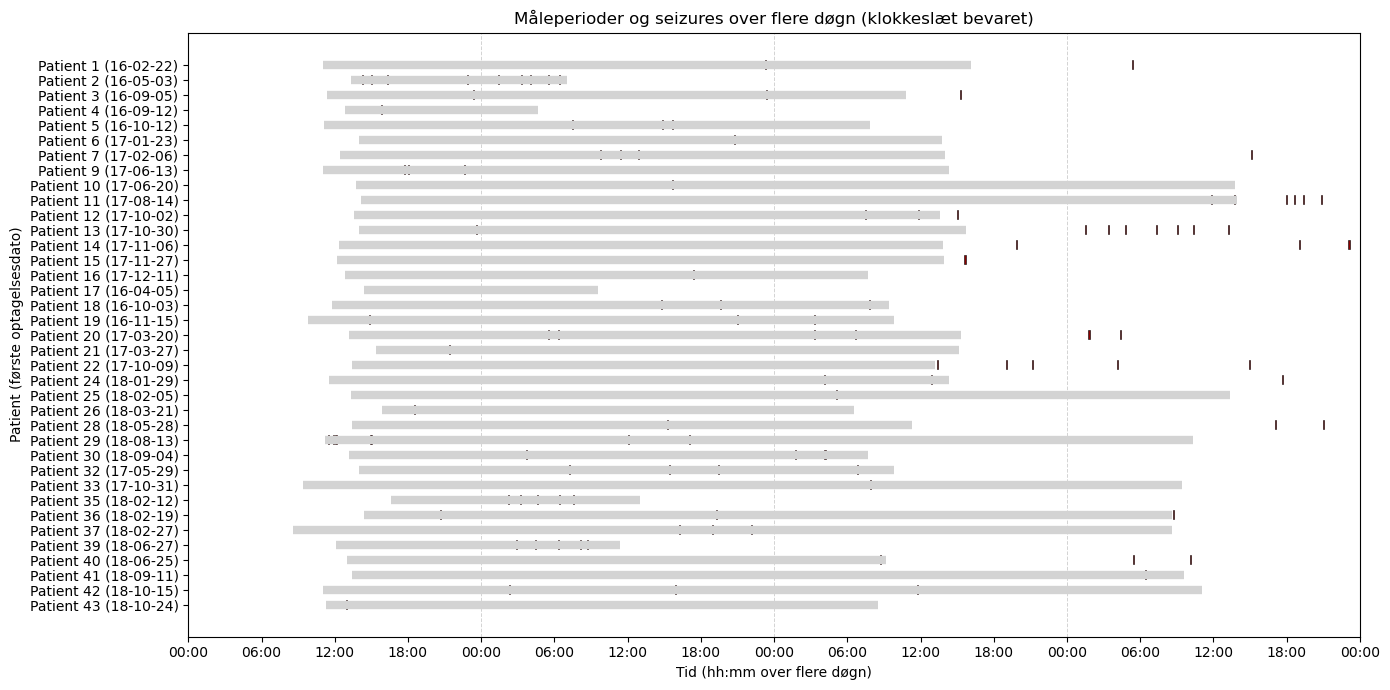

In [30]:
plot_patient_seizure_timeline_multiday_clocklabels(all_patients, max_hours=96.0)


In [15]:
from src.hrv_epatch.io.labview import read_labview_rr, read_header_datetime_lvm
from src.hrv_epatch.io.data_loader import Load_full_ecg_data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

patient_ids = [f"Patient {i}" for i in range(1, 44)]

raw_patients = []

for patient_id in patient_ids[:4]:  # eller hele listen
    res = Load_full_ecg_data(patient_id)

    ecg_signal = res["ECG"]
    fs = res["SampleRate"]
    rec_duration_s = len(ecg_signal) / fs

    seizure_events_df = res["Seizures"]
    start_dt = pd.to_datetime(res["StartTime"])  # optagelsens start-tidspunkt

    # Byg en simpel liste af objekter med t0/t1 i SEKUNDER fra recording start
    seizure_list = []
    for _, row in seizure_events_df.iterrows():
        try:
            start_time = row["Anfaldsstart EEG (tt:mm:ss)"]
            end_time = row["Anfaldstop EEG (tt:mm:ss)"]
            if pd.notna(start_time) and pd.notna(end_time):
                # Tid i sekunder fra midnat (hh:mm:ss → sek)
                t0 = sum(int(x) * 60**i for i, x in enumerate(reversed(str(start_time).split(":"))))
                t1 = sum(int(x) * 60**i for i, x in enumerate(reversed(str(end_time).split(":"))))
                # Dummy “event-objekt” med attributter t0/t1 (sek fra recording start)
                ev = type("SeizureEvent", (object,), {"t0": float(t0), "t1": float(t1)})()
                seizure_list.append(ev)
        except Exception as e:
            print(f"Error processing seizure event for {patient_id}: {e}")

    raw_patients.append({
        "patient_id": patient_id,
        "start_dt": start_dt,
        "rec_duration_s": rec_duration_s,
        "seizure_events": seizure_list,
    })

# Fælles reference: første recording start på tværs af patienter
global_start = min(p["start_dt"] for p in raw_patients)

all_patients = []
for p in raw_patients:
    offset_h = (p["start_dt"] - global_start).total_seconds() / 3600.0
    all_patients.append({
        "patient_id": p["patient_id"],
        "rec_start_h": offset_h,                         # starttid i timer fra global_start
        "rec_duration_h": p["rec_duration_s"] / 3600.0,  # varighed i timer
        "seizure_events": p["seizure_events"],
    })


In [16]:
def plot_patient_seizure_timeline(
    all_patients,
    max_hours: float = 96.0,
    day_grid: bool = True,
    figsize=(10, 6),
):
    """
    all_patients: liste af dicts med keys:
        - patient_id: str
        - rec_start_h: float  (starttid i timer fra global_start)
        - rec_duration_h: float
        - seizure_events: liste af objekter med .t0, .t1 (sek fra rec start)
    """
    patients = [p["patient_id"] for p in all_patients]
    n_patients = len(patients)
    y_positions = np.arange(n_patients)

    fig, ax = plt.subplots(figsize=figsize)

    for i, pdata in enumerate(all_patients):
        pid = pdata["patient_id"]
        rec_start_h = pdata["rec_start_h"]
        rec_duration_h = min(pdata["rec_duration_h"], max_hours)

        # baseline måleperiode som en tyk grå linje
        ax.hlines(
            y=i,
            xmin=rec_start_h,
            xmax=rec_start_h + rec_duration_h,
            color="lightgray",
            linewidth=6,
            zorder=1,
        )

        # seizures som røde blokke
        for ev in pdata["seizure_events"]:
            # ev.t0 / ev.t1 er i sek fra recording start → konverter til timer
            start_h = rec_start_h + ev.t0 / 3600.0
            end_h = rec_start_h + ev.t1 / 3600.0

            if end_h <= 0 or start_h >= max_hours:
                continue
            start_h = max(start_h, 0.0)
            end_h = min(end_h, max_hours)

            ax.broken_barh(
                [(start_h, end_h - start_h)],
                (i - 0.3, 0.6),
                facecolors="tab:red",
                edgecolors="k",
                linewidth=0.5,
                zorder=2,
            )

    # akselabels og ticks
    ax.set_yticks(y_positions)
    ax.set_yticklabels(patients)
    ax.set_xlabel("Tid [timer fra første optagelsesstart]")
    ax.set_ylabel("Patient")

    ax.set_xlim(0, max_hours)
    ax.set_ylim(-1, n_patients)

    # vend rækkefølgen så Patient 1 kommer øverst
    ax.invert_yaxis()

    # lodrette linjer ved døgnskel
    if day_grid:
        for d in range(0, int(max_hours) + 1, 24):
            ax.axvline(d, color="lightgray", linestyle="--", linewidth=0.7, zorder=0)

    ax.set_xticks(np.arange(0, max_hours + 1, 12))
    ax.grid(axis="x", linestyle=":", alpha=0.3)

    ax.set_title("Oversigt over måleperioder og seizures for alle patienter")
    plt.tight_layout()
    plt.show()


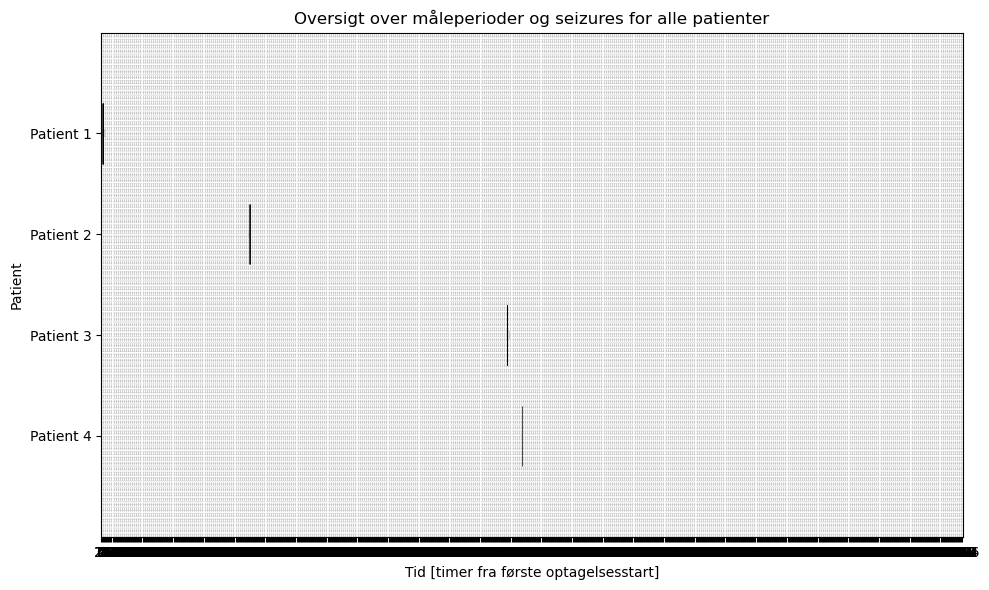

In [18]:
plot_patient_seizure_timeline(all_patients, max_hours=10000.0)


In [ ]:


def plot_patient_seizure_timeline(
    all_patients,
    max_hours: float = 96.0,
    day_grid: bool = True,
    figsize=(10, 6),
):
    """
    all_patients: liste af dicts med keys:
        - patient_id: str
        - rec_duration_s: float
        - seizure_events: liste af objekter med .t0, .t1 (sek fra rec start)
    """
    patients = [p["patient_id"] for p in all_patients]
    n_patients = len(patients)
    y_positions = np.arange(n_patients)

    fig, ax = plt.subplots(figsize=figsize)

    for i, pdata in enumerate(all_patients):
        pid = pdata["patient_id"]
        rec_duration_h = min(pdata["rec_duration_s"] / 3600.0, max_hours)

        # baseline måleperiode som en tyk grå linje
        ax.hlines(
            y=i,
            xmin=0.0,
            xmax=rec_duration_h,
            color="lightgray",
            linewidth=6,
            zorder=1,
        )

        # seizures som røde blokke
        for ev in pdata["seizure_events"]:
            start_h = ev.t0 / 3600.0
            end_h = ev.t1 / 3600.0
            if end_h <= 0 or start_h >= max_hours:
                continue
            start_h = max(start_h, 0.0)
            end_h = min(end_h, max_hours)
            ax.broken_barh(
                [(start_h, end_h - start_h)],
                (i - 0.3, 0.6),
                facecolors="tab:red",
                edgecolors="k",
                linewidth=0.5,
                zorder=2,
            )

    # akselabels og ticks
    ax.set_yticks(y_positions)
    ax.set_yticklabels(patients)
    ax.set_xlabel("Tid siden måle-start [timer]")
    ax.set_ylabel("Patient")

    ax.set_xlim(0, max_hours)
    ax.set_ylim(-1, n_patients)

    # lodrette linjer ved døgnskel
    if day_grid:
        for d in range(0, int(max_hours) + 1, 24):
            ax.axvline(d, color="lightgray", linestyle="--", linewidth=0.7, zorder=0)

    ax.set_xticks(np.arange(0, max_hours + 1, 12))
    ax.grid(axis="x", linestyle=":", alpha=0.3)

    ax.set_title("Oversigt over måleperioder og seizures for alle patienter")

    plt.tight_layout()
    plt.show()

for patient_id in patient_ids[:4]:  # Iterate through all patients
    # Load data for the current patient
    res = Load_full_ecg_data(patient_id)
    
    ecg_signal = res["ECG"]
    rec_duration_s = len(ecg_signal) / res["SampleRate"]
    seizure_events = res["Seizures"]

    # Extract seizure events with start and end times in seconds
    seizure_list = []
    for _, row in seizure_events.iterrows():
        try:
            start_time = row["Anfaldsstart EEG (tt:mm:ss)"]
            end_time = row["Anfaldstop EEG (tt:mm:ss)"]
            if start_time and end_time:
                # Convert time to seconds from the start of the recording
                t0 = sum(int(x) * 60 ** i for i, x in enumerate(reversed(start_time.split(":"))))
                t1 = sum(int(x) * 60 ** i for i, x in enumerate(reversed(end_time.split(":"))))
                seizure_list.append(type("SeizureEvent", (object,), {"t0": t0, "t1": t1})())
        except Exception as e:
            print(f"Error processing seizure event for {patient_id}: {e}")

    # Append patient data to the list
    all_patients.append({
        "patient_id": patient_id,
        "rec_duration_s": rec_duration_s,
        "seizure_events": seizure_list,
    })

# Plot the seizure timeline for all patients
plot_patient_seizure_timeline(all_patients, max_hours=96.0)